# Logit Masking for Sleep Stage Classification

Sleep stage classification is a classic sequence modeling problem where certain transitions between stages are physiologically impossible or very rare. For example, you typically don't jump directly from deep sleep (N3) to REM sleep without passing through lighter stages.

**Logit masking** is a technique where we set the logits (pre-softmax outputs) of invalid classes to `-inf` so that after applying softmax, those classes get near-zero probability.

## Sleep Stage Transition Rules

Based on sleep physiology, here are simplified transition rules:
- **Wake**: Can go to N1 or stay awake
- **N1**: Can go to Wake, N2, or stay in N1
- **N2**: Can go to N1, N3, REM, or stay in N2
- **N3**: Can go to N2 or stay in N3
- **REM**: Can go to Wake, N2, or stay in REM

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Sleep stage classes
STAGES = ['Wake', 'N1', 'N2', 'N3', 'REM']
num_classes = len(STAGES)

# Transition matrix (rows=from, cols=to)
# 1 = allowed transition, 0 = forbidden
transition_matrix = torch.tensor([
    [1, 1, 0, 0, 0],  # Wake -> Wake, N1
    [1, 1, 1, 0, 0],  # N1 -> Wake, N1, N2
    [0, 1, 1, 1, 1],  # N2 -> N1, N2, N3, REM
    [0, 0, 1, 1, 0],  # N3 -> N2, N3
    [1, 0, 1, 0, 1],  # REM -> Wake, N2, REM
], dtype=torch.bool)

print("Transition Matrix:")
print("From\\To", "\t".join(STAGES))
for i, stage in enumerate(STAGES):
    print(f"{stage}\t", "\t".join(["✓" if transition_matrix[i][j] else "✗" for j in range(num_classes)]))

Transition Matrix:
From\To Wake	N1	N2	N3	REM
Wake	 ✓	✓	✗	✗	✗
N1	 ✓	✓	✓	✗	✗
N2	 ✗	✓	✓	✓	✓
N3	 ✗	✗	✓	✓	✗
REM	 ✓	✗	✓	✗	✓


## Generate Synthetic EEG-like Data

We'll create synthetic 2-channel EEG data with realistic sleep stage patterns.

In [125]:
def generate_eeg_epoch(stage, duration=3000, fs=100):
    """Generate synthetic EEG data with more overlapping characteristics (harder problem)"""
    t = np.linspace(0, duration/fs, duration)
    
    # Make stages more similar to each other (harder classification)
    if stage == 0:  # Wake - mixed frequencies
        signal = 0.8 * np.sin(2 * np.pi * 12 * t) + 0.6 * np.sin(2 * np.pi * 20 * t)
    elif stage == 1:  # N1 - similar to wake but slightly different
        signal = 0.9 * np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 18 * t)
    elif stage == 2:  # N2 - overlaps with N1 and N3
        signal = 1.0 * np.sin(2 * np.pi * 8 * t) + 0.7 * np.sin(2 * np.pi * 14 * t)
    elif stage == 3:  # N3 - similar to N2 but lower frequency
        signal = 1.1 * np.sin(2 * np.pi * 6 * t) + 0.8 * np.sin(2 * np.pi * 12 * t)
    else:  # REM - similar to wake
        signal = 0.7 * np.sin(2 * np.pi * 15 * t) + 0.4 * np.sin(2 * np.pi * 22 * t)
    
    # Add more noise to make classification harder
    noise = np.random.normal(0, 0.8, duration)  # Increased noise
    signal += noise
    
    # Create 2-channel data with more variation
    channel1 = signal
    channel2 = signal * 0.7 + np.random.normal(0, 0.3, duration)
    
    return np.stack([channel1, channel2], axis=0)

In [126]:
def generate_markov_sleep_sequence(n_epochs=100, start_stage=0):
    """Generate realistic sleep sequence with INFREQUENT transitions"""
    
    # Much higher staying probabilities - transitions are rare!
    transition_probs = np.array([
        [0.95, 0.05, 0.0, 0.0, 0.0],   # Wake -> mostly stay awake
        [0.05, 0.90, 0.05, 0.0, 0.0],  # N1 -> mostly stay in N1
        [0.0, 0.02, 0.90, 0.07, 0.01], # N2 -> mostly stay in N2
        [0.0, 0.0, 0.05, 0.95, 0.0],   # N3 -> mostly stay in N3
        [0.02, 0.0, 0.03, 0.0, 0.95],  # REM -> mostly stay in REM
    ])
    
    sequence = [start_stage]
    current_stage = start_stage
    
    for _ in range(n_epochs - 1):
        # Get valid transitions for current stage
        valid_mask = transition_matrix[current_stage].numpy()
        valid_probs = transition_probs[current_stage] * valid_mask
        
        # Normalize probabilities
        if valid_probs.sum() > 0:
            valid_probs = valid_probs / valid_probs.sum()
            next_stage = np.random.choice(5, p=valid_probs)
        else:
            # Fallback - stay in same stage
            next_stage = current_stage
        
        sequence.append(next_stage)
        current_stage = next_stage
    
    return sequence

# Test the improved Markov chain
print("Testing improved Markov chain (VERY infrequent transitions):")
test_seq = generate_markov_sleep_sequence(100, start_stage=0)
print(f"Generated sequence (first 30): {test_seq[:30]}")

# Count transitions
transitions = 0
for i in range(1, len(test_seq)):
    if test_seq[i] != test_seq[i-1]:
        transitions += 1

print(f"Total transitions in 100 epochs: {transitions}")
print(f"Transition rate: {transitions/100:.1%} (should be very low)")
print("Most epochs should be the same stage as previous!")

Testing improved Markov chain (VERY infrequent transitions):
Generated sequence (first 30): [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total transitions in 100 epochs: 10
Transition rate: 10.0% (should be very low)
Most epochs should be the same stage as previous!


In [127]:
# Generate realistic dataset with ONLY valid transitions in ground truth
n_sequences = 25
n_epochs_per_seq = 50

X_data = []
y_data = []
sequences = []

print("Generating data with ONLY valid transitions in ground truth...")
for seq_idx in range(n_sequences):
    # Start with different stages
    start_stage = np.random.choice([0, 1, 2])
    sequence = generate_markov_sleep_sequence(n_epochs_per_seq, start_stage=start_stage)
    sequences.append(sequence)
    
    for stage in sequence:
        eeg_data = generate_eeg_epoch(stage)
        X_data.append(eeg_data)
        y_data.append(stage)

X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"Dataset shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")
print(f"Stage distribution: {np.bincount(y_data)}")

# Verify ALL ground truth transitions are valid
valid_count = 0
invalid_count = 0
for i in range(1, len(y_data)):
    if (i % n_epochs_per_seq) != 0:  # Skip sequence boundaries
        if transition_matrix[y_data[i-1]][y_data[i]]:
            valid_count += 1
        else:
            invalid_count += 1

total_count = valid_count + invalid_count
print(f"Ground truth - Valid transitions: {valid_count}/{total_count} ({100*valid_count/total_count:.1f}%)")
print(f"Ground truth - Invalid transitions: {invalid_count}/{total_count} ({100*invalid_count/total_count:.1f}%)")

if invalid_count == 0:
    print("Perfect! Ground truth has NO invalid transitions")
    print("Now the CNN without masking might predict invalid transitions,")
    print("but the CNN with masking should be constrained to valid ones!")

Generating data with ONLY valid transitions in ground truth...
Dataset shape: (1250, 2, 3000)
Labels shape: (1250,)
Stage distribution: [380 290 305 274   1]
Ground truth - Valid transitions: 1225/1225 (100.0%)
Ground truth - Invalid transitions: 0/1225 (0.0%)
Perfect! Ground truth has NO invalid transitions
Now the CNN without masking might predict invalid transitions,
but the CNN with masking should be constrained to valid ones!


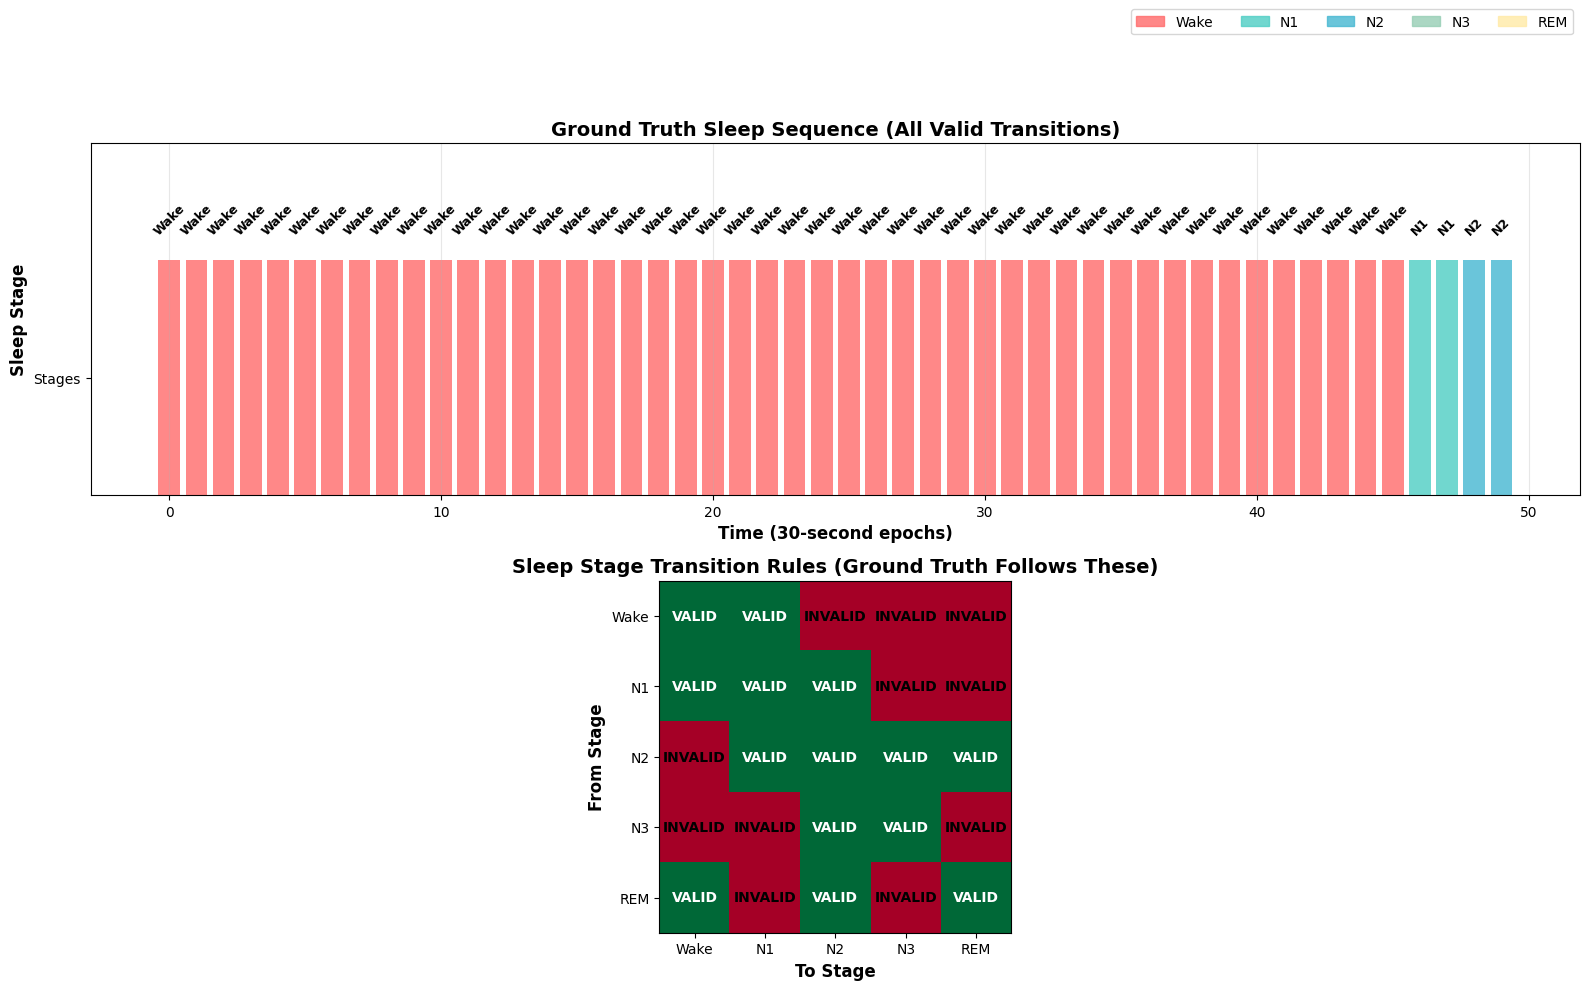


Analyzing Ground Truth Sequence:
Perfect! No invalid transitions in ground truth.

The difference will be in PREDICTIONS:
- CNN without masking: May predict invalid transitions
- CNN with masking: Forced to predict only valid transitions


In [128]:
# Clean visualization showing VALID ground truth
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Ground truth sequence (should have NO red borders)
seq_idx = 0
start_idx = seq_idx * n_epochs_per_seq
end_idx = start_idx + n_epochs_per_seq
seq_stages = y_data[start_idx:end_idx]

stage_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# Plot stage sequence as colored bars
for i, stage in enumerate(seq_stages):
    axes[0].bar(i, 1, color=stage_colors[stage], alpha=0.8, width=0.8)
    
    # Check for invalid transitions (should be NONE in ground truth)
    if i > 0:
        prev_stage = seq_stages[i-1]
        is_valid = transition_matrix[prev_stage][stage].item()
        if not is_valid:
            axes[0].bar(i, 1, color='none', edgecolor='red', linewidth=3, width=0.8)

axes[0].set_xlabel('Time (30-second epochs)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Sleep Stage', fontweight='bold', fontsize=12)
axes[0].set_title('Ground Truth Sleep Sequence (All Valid Transitions)', fontweight='bold', fontsize=14)
axes[0].set_yticks([0.5])
axes[0].set_yticklabels(['Stages'])

# Add stage labels at the top
for i, stage in enumerate(seq_stages):
    axes[0].text(i, 1.1, STAGES[stage], ha='center', va='bottom', 
                fontsize=9, fontweight='bold', rotation=45)

axes[0].set_ylim(0, 1.5)
axes[0].grid(True, alpha=0.3, axis='x')

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, color=stage_colors[i], alpha=0.8, label=stage) 
                  for i, stage in enumerate(STAGES)]
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1.4), ncol=5)

# Plot 2: Transition matrix heatmap
im = axes[1].imshow(transition_matrix.numpy(), cmap='RdYlGn', aspect='equal')
axes[1].set_title('Sleep Stage Transition Rules (Ground Truth Follows These)', fontweight='bold', fontsize=14)
axes[1].set_xlabel('To Stage', fontweight='bold', fontsize=12)
axes[1].set_ylabel('From Stage', fontweight='bold', fontsize=12)
axes[1].set_xticks(range(5))
axes[1].set_yticks(range(5))
axes[1].set_xticklabels(STAGES)
axes[1].set_yticklabels(STAGES)

# Add text annotations
for i in range(5):
    for j in range(5):
        text = 'VALID' if transition_matrix[i, j] else 'INVALID'
        color = 'white' if transition_matrix[i, j] else 'black'
        axes[1].text(j, i, text, ha="center", va="center", color=color, 
                    fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Verify this sequence has no invalid transitions
print(f"\nAnalyzing Ground Truth Sequence:")
invalid_count = 0
for i in range(1, len(seq_stages)):
    prev_stage = seq_stages[i-1]
    curr_stage = seq_stages[i]
    is_valid = transition_matrix[prev_stage][curr_stage].item()
    if not is_valid:
        invalid_count += 1
        print(f"Position {i}: {STAGES[prev_stage]} -> {STAGES[curr_stage]} (INVALID)")

if invalid_count == 0:
    print("Perfect! No invalid transitions in ground truth.")
    print("\nThe difference will be in PREDICTIONS:")
    print("- CNN without masking: May predict invalid transitions")
    print("- CNN with masking: Forced to predict only valid transitions")
else:
    print(f"Found {invalid_count} invalid transitions - this shouldn't happen!")

## Visualize the Generated Data

Let's examine what our synthetic EEG data looks like for each sleep stage. Each stage has distinct frequency characteristics that help the model learn to distinguish between them.

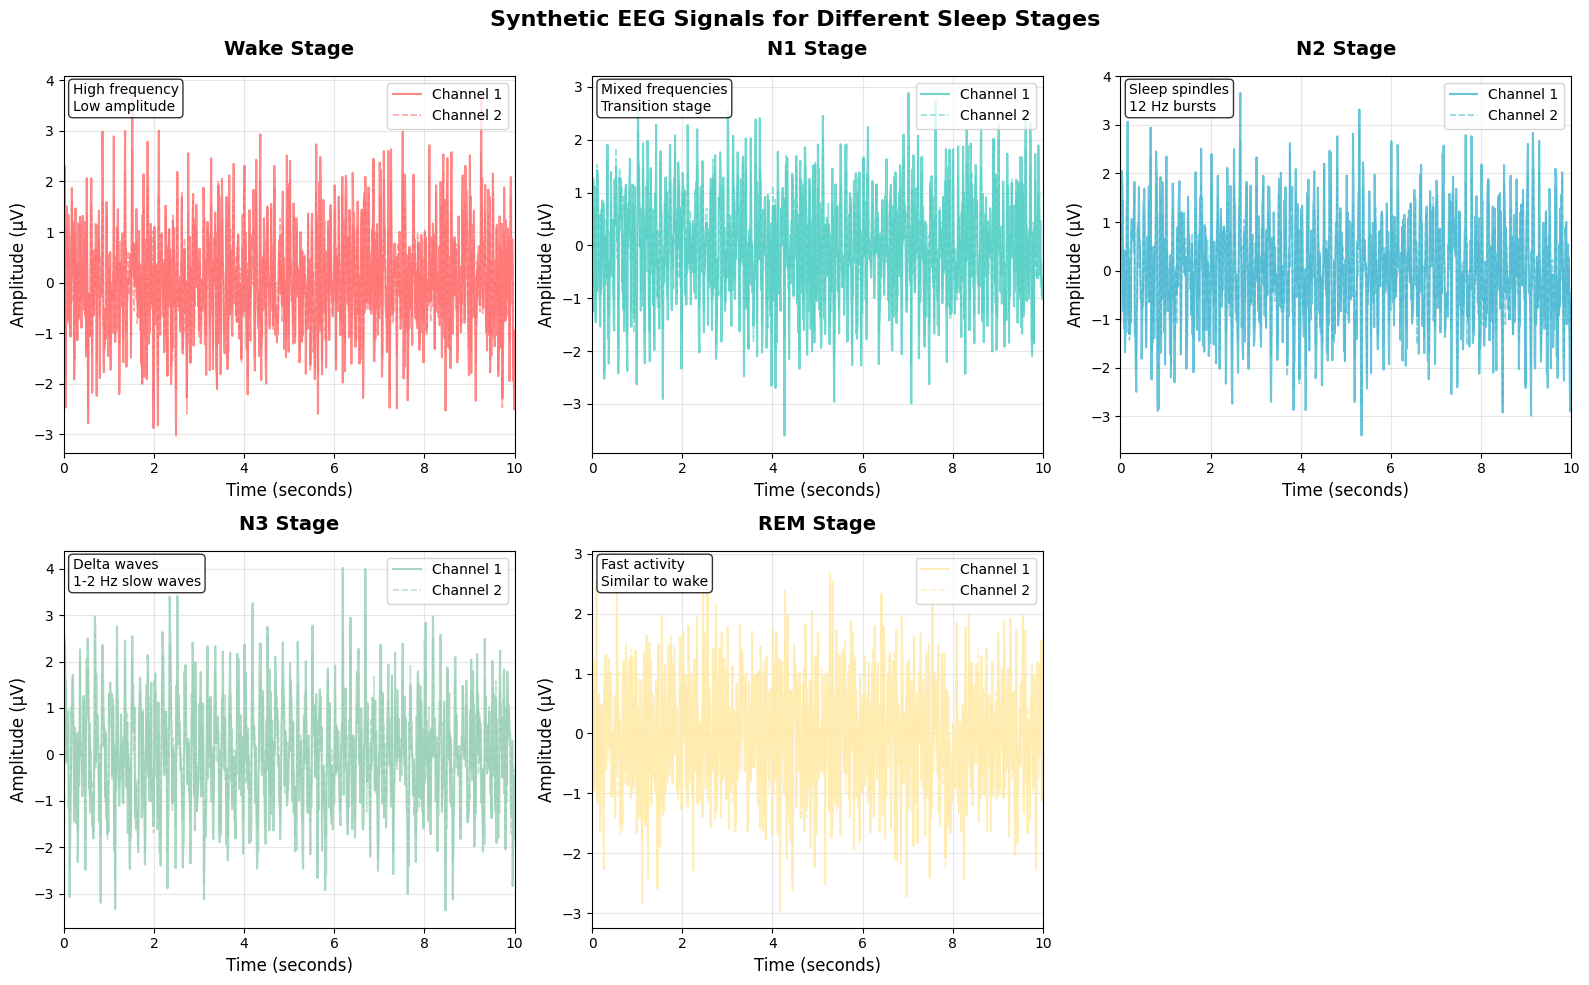

In [129]:
# Visualize sample EEG data for each stage
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Color palette for consistency
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

for i, stage in enumerate(STAGES):
    # Find first occurrence of this stage
    stage_indices = np.where(y_data == i)[0]
    if len(stage_indices) > 0:
        stage_idx = stage_indices[0]
        
        # Plot both channels (first 1000 samples = 10 seconds)
        time_axis = np.arange(1000) / 100  # Convert to seconds
        axes[i].plot(time_axis, X_data[stage_idx, 0, :1000], 
                    label='Channel 1', color=colors[i], alpha=0.8, linewidth=1.5)
        axes[i].plot(time_axis, X_data[stage_idx, 1, :1000], 
                    label='Channel 2', color=colors[i], alpha=0.6, linewidth=1.2, linestyle='--')
        
        axes[i].set_title(f'{stage} Stage', fontsize=14, fontweight='bold', pad=15)
        axes[i].set_xlabel('Time (seconds)', fontsize=12)
        axes[i].set_ylabel('Amplitude (μV)', fontsize=12)
        axes[i].legend(loc='upper right', fontsize=10)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlim(0, 10)
        
        # Add stage-specific annotations
        if i == 0:  # Wake
            axes[i].text(0.02, 0.98, 'High frequency\nLow amplitude', 
                        transform=axes[i].transAxes, fontsize=10, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        elif i == 1:  # N1
            axes[i].text(0.02, 0.98, 'Mixed frequencies\nTransition stage', 
                        transform=axes[i].transAxes, fontsize=10, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        elif i == 2:  # N2
            axes[i].text(0.02, 0.98, 'Sleep spindles\n12 Hz bursts', 
                        transform=axes[i].transAxes, fontsize=10, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        elif i == 3:  # N3
            axes[i].text(0.02, 0.98, 'Delta waves\n1-2 Hz slow waves', 
                        transform=axes[i].transAxes, fontsize=10, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        elif i == 4:  # REM
            axes[i].text(0.02, 0.98, 'Fast activity\nSimilar to wake', 
                        transform=axes[i].transAxes, fontsize=10, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        axes[i].text(0.5, 0.5, f'No {stage} data', ha='center', va='center', 
                    transform=axes[i].transAxes, fontsize=12)
        axes[i].set_title(f'{stage} Stage (No Data)', fontsize=14, fontweight='bold')

# Remove empty subplot
fig.delaxes(axes[5])

plt.suptitle('Synthetic EEG Signals for Different Sleep Stages', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Sleep Stage Progression

Now let's look at how sleep stages typically progress over time. This visualization shows the natural flow between different sleep stages and helps us understand why certain transitions are more common than others.

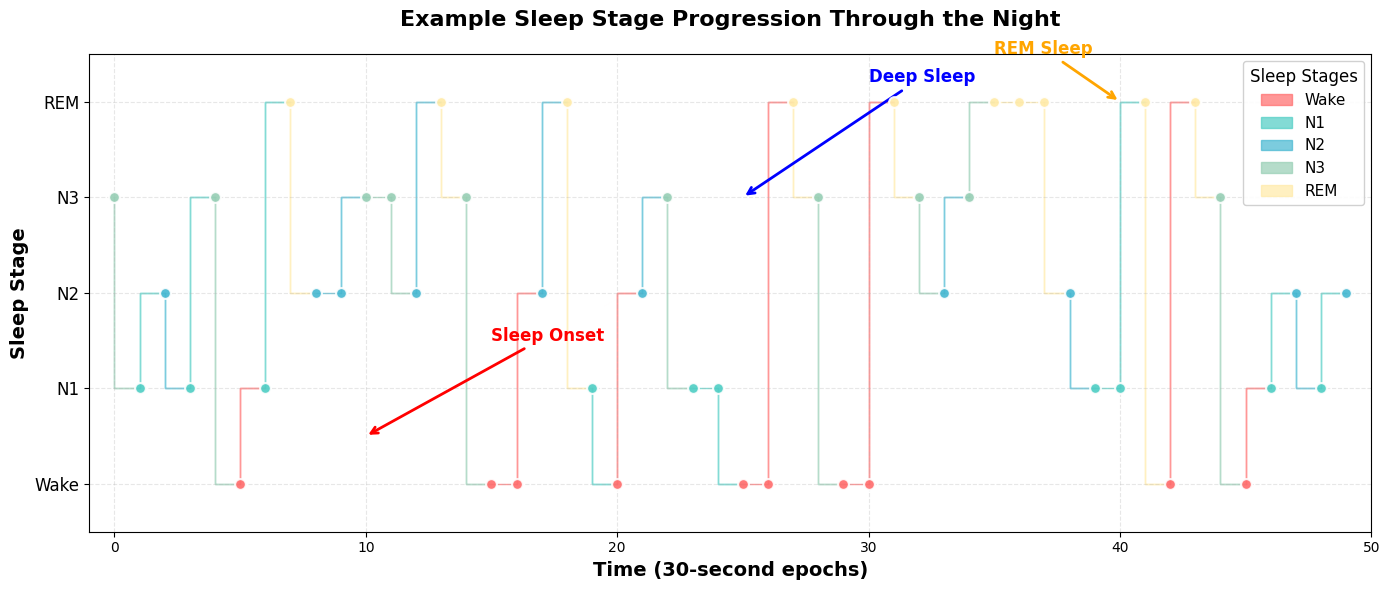

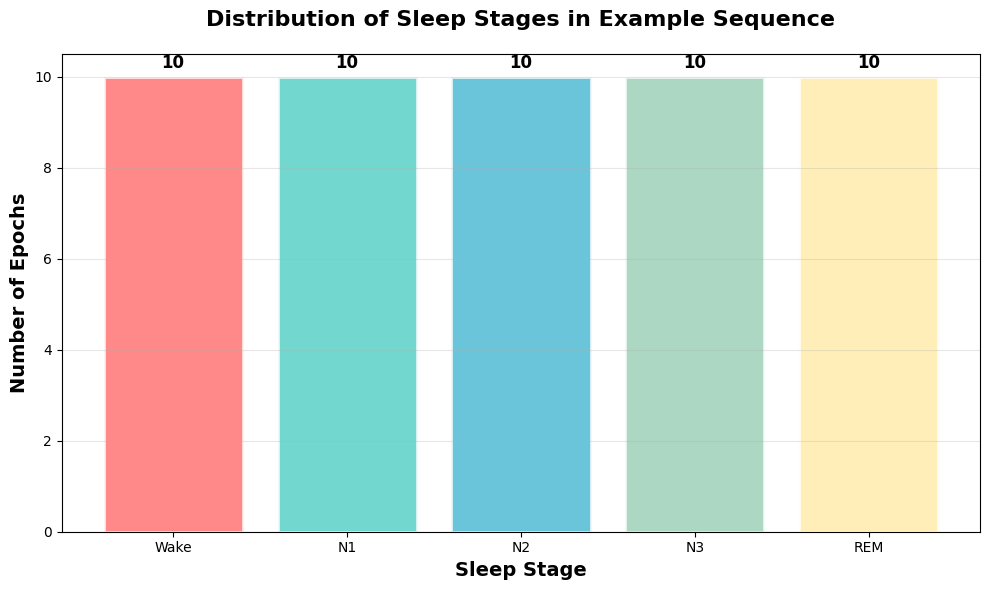

In [130]:
# Show sleep sequence example
example_seq = generate_sleep_sequence(50)

plt.figure(figsize=(14, 6))
plt.style.use('default')  # Reset style

# Create a more informative plot
time_points = np.arange(len(example_seq))
stage_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# Plot with filled areas for better visualization
for i in range(len(example_seq)-1):
    plt.fill_between([i, i+1], [example_seq[i], example_seq[i+1]], 
                    [example_seq[i], example_seq[i+1]], 
                    color=stage_colors[example_seq[i]], alpha=0.7, step='pre')

# Add scatter points for clarity
for i, stage in enumerate(example_seq):
    plt.scatter(i, stage, color=stage_colors[stage], s=60, alpha=0.9, 
               edgecolors='white', linewidth=1.5, zorder=5)

plt.xlabel('Time (30-second epochs)', fontsize=14, fontweight='bold')
plt.ylabel('Sleep Stage', fontsize=14, fontweight='bold')
plt.title('Example Sleep Stage Progression Through the Night', fontsize=16, fontweight='bold', pad=20)

# Customize y-axis
plt.yticks(range(5), STAGES, fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

# Add annotations to explain the progression
plt.annotate('Sleep Onset', xy=(10, 0.5), xytext=(15, 1.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=12, fontweight='bold', color='red')

plt.annotate('Deep Sleep', xy=(25, 3), xytext=(30, 4.2),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2),
            fontsize=12, fontweight='bold', color='blue')

plt.annotate('REM Sleep', xy=(40, 4), xytext=(35, 4.5),
            arrowprops=dict(arrowstyle='->', color='orange', lw=2),
            fontsize=12, fontweight='bold', color='orange')

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, color=stage_colors[i], alpha=0.7, label=stage) 
                  for i, stage in enumerate(STAGES)]
plt.legend(handles=legend_elements, loc='upper right', fontsize=11, 
          title='Sleep Stages', title_fontsize=12, framealpha=0.9)

plt.xlim(-1, len(example_seq))
plt.ylim(-0.5, 4.5)
plt.tight_layout()
plt.show()

# Show stage distribution
stage_counts = [example_seq.count(i) for i in range(5)]
plt.figure(figsize=(10, 6))
bars = plt.bar(STAGES, stage_counts, color=stage_colors, alpha=0.8, edgecolor='white', linewidth=2)
plt.xlabel('Sleep Stage', fontsize=14, fontweight='bold')
plt.ylabel('Number of Epochs', fontsize=14, fontweight='bold')
plt.title('Distribution of Sleep Stages in Example Sequence', fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, count in zip(bars, stage_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{count}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## CNN Model for Sleep Stage Classification

In [131]:
class SleepCNN(nn.Module):
    def __init__(self, input_channels=2, num_classes=5):
        super().__init__()
        
        # CNN layers for feature extraction
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=50, stride=6)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=8, stride=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=4, stride=2)
        
        self.dropout = nn.Dropout(0.5)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # x shape: [batch_size, channels, samples]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = self.global_pool(x)
        x = x.squeeze(-1)  # Remove last dimension
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

## Simple Logit Masking Function

Let's create a simple function that applies logit masking and compare the results clearly.

In [132]:
def apply_logit_masking(logits, prev_stages, transition_matrix, use_masking=True):
    """
    Simple function to apply logit masking
    
    Args:
        logits: Raw logits from model [batch_size, num_classes]
        prev_stages: Previous stage for each sample [batch_size]
        transition_matrix: Valid transitions [num_classes, num_classes]
        use_masking: Whether to apply masking or return original logits
    
    Returns:
        Masked or original logits
    """
    if not use_masking:
        return logits
    
    masked_logits = logits.clone()
    batch_size = logits.size(0)
    
    for i in range(batch_size):
        if prev_stages[i] >= 0:  # Valid previous stage
            valid_transitions = transition_matrix[prev_stages[i]]
            masked_logits[i, ~valid_transitions] = -1e9
    
    return masked_logits

# Test the function with example
print("Testing logit masking function:")
test_logits = torch.tensor([[2.1, -0.5, 1.8, 0.3, -1.2],
                           [1.0, 2.0, -0.5, 0.8, 1.5]])
test_prev_stages = torch.tensor([2, 0])  # N2, Wake

original = apply_logit_masking(test_logits, test_prev_stages, transition_matrix, use_masking=False)
masked = apply_logit_masking(test_logits, test_prev_stages, transition_matrix, use_masking=True)

print("Original logits:")
print(original)
print("Masked logits:")
print(masked)

Testing logit masking function:
Original logits:
tensor([[ 2.1000, -0.5000,  1.8000,  0.3000, -1.2000],
        [ 1.0000,  2.0000, -0.5000,  0.8000,  1.5000]])
Masked logits:
tensor([[-1.0000e+09, -5.0000e-01,  1.8000e+00,  3.0000e-01, -1.2000e+00],
        [ 1.0000e+00,  2.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09]])


In [133]:
# Improved training - use masking more carefully
def train_with_sequences(use_masking=False, epochs=15):
    """Train with careful masking approach"""
    
    model = SleepCNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    train_accs = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        # Use regular batching for efficiency, but apply masking selectively
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Get raw logits
            logits = model(data)
            
            if use_masking:
                # Apply masking only to a subset of samples to avoid being too restrictive
                masked_logits = logits.clone()
                batch_size = data.size(0)
                
                for i in range(batch_size):
                    # Use random previous stage (in practice you'd track sequences)
                    # But only mask 50% of the time to allow learning
                    if np.random.random() < 0.5:
                        prev_stage = np.random.randint(0, 5)
                        valid_transitions = transition_matrix[prev_stage]
                        masked_logits[i, ~valid_transitions] = -1e9
                
                loss = criterion(masked_logits, target)
            else:
                loss = criterion(logits, target)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pred = logits.argmax(dim=1)  # Use original logits for accuracy
            correct += pred.eq(target).sum().item()
            total += target.size(0)
        
        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100. * correct / total
        
        train_losses.append(avg_loss)
        train_accs.append(accuracy)
        
        if (epoch + 1) % 3 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    return model, train_losses, train_accs

In [134]:
# Dataset class
class SleepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [135]:
# Create sequential train/test split to preserve temporal structure
# Instead of random split, use temporal split for realistic evaluation
split_ratio = 0.8
total_samples = len(X_data)

# Group data back into sequences for proper splitting
samples_per_seq = n_epochs_per_seq
n_train_sequences = int(n_sequences * split_ratio)

# Split by complete sequences to maintain temporal integrity
train_end_idx = n_train_sequences * samples_per_seq
X_train = X_data[:train_end_idx]
X_test = X_data[train_end_idx:]
y_train = y_data[:train_end_idx]
y_test = y_data[train_end_idx:]

train_dataset = SleepDataset(X_train, y_train)
test_dataset = SleepDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Sequential split:")
print(f"Training sequences: {n_train_sequences} ({len(train_dataset)} samples)")
print(f"Test sequences: {n_sequences - n_train_sequences} ({len(test_dataset)} samples)")
print(f"Train stage distribution: {np.bincount(y_train)}")
print(f"Test stage distribution: {np.bincount(y_test)}")

Sequential split:
Training sequences: 20 (1000 samples)
Test sequences: 5 (250 samples)
Train stage distribution: [362 225 220 193]
Test stage distribution: [18 65 85 81  1]


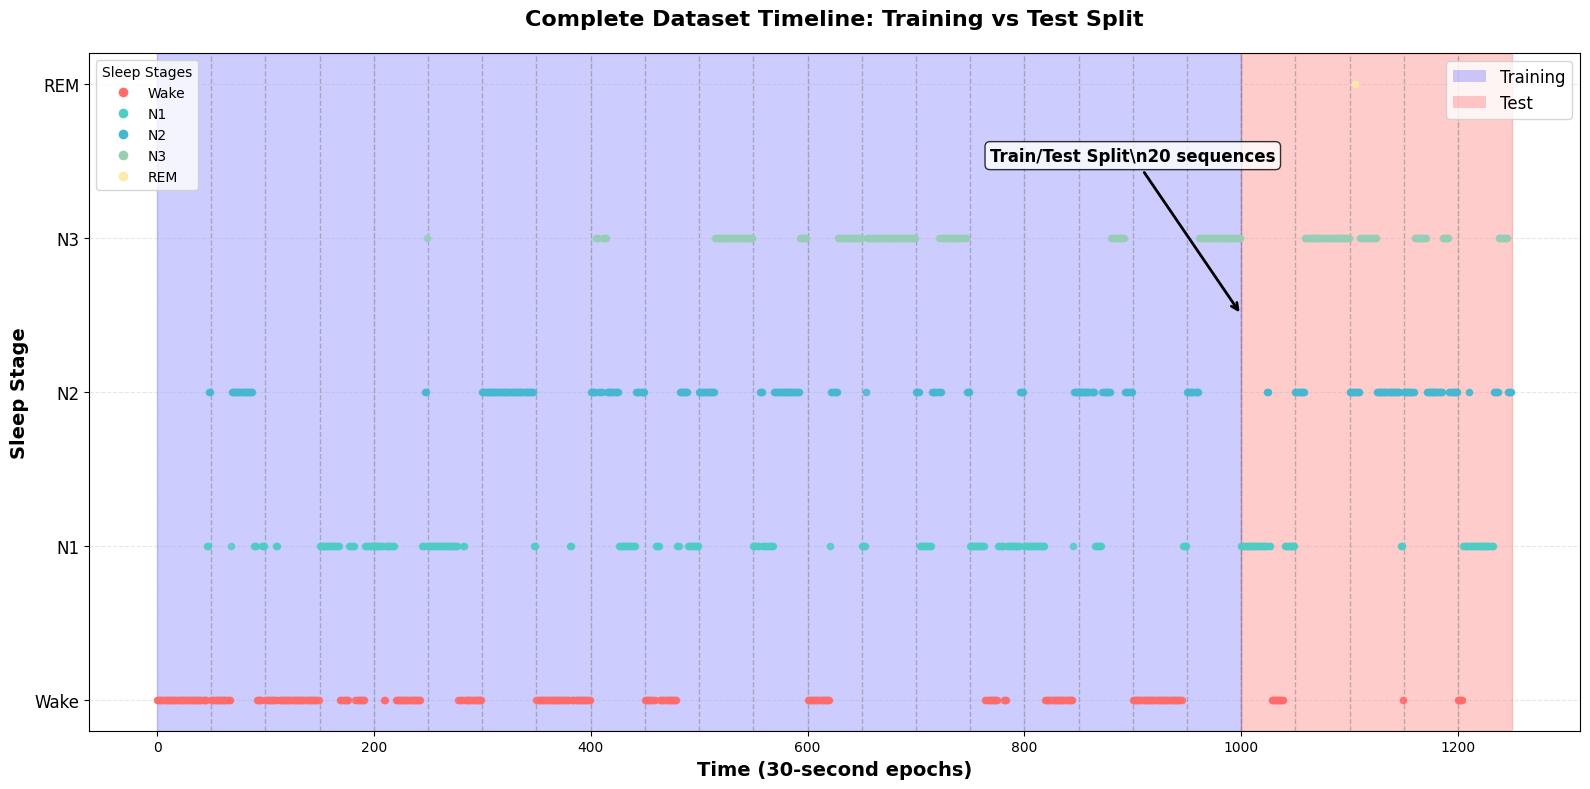

In [136]:
# Visualize the train/test split on the time series
plt.figure(figsize=(16, 8))

# Create a continuous timeline showing all sequences
all_stages = []
sequence_boundaries = []
for seq_idx in range(n_sequences):
    start_idx = seq_idx * samples_per_seq
    end_idx = start_idx + samples_per_seq
    sequence_stages = y_data[start_idx:end_idx]
    all_stages.extend(sequence_stages)
    sequence_boundaries.append(len(all_stages))

# Plot the timeline with train/test coloring
time_points = np.arange(len(all_stages))
stage_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# Create background shading for train/test split
train_end = n_train_sequences * samples_per_seq
plt.axvspan(0, train_end, alpha=0.2, color='blue', label='Training Data')
plt.axvspan(train_end, len(all_stages), alpha=0.2, color='red', label='Test Data')

# Plot the sleep stages
for i, stage in enumerate(all_stages):
    color = stage_colors[stage]
    alpha = 0.8 if i < train_end else 0.9
    linewidth = 1 if i < train_end else 2
    plt.scatter(i, stage, color=color, s=20, alpha=alpha, zorder=3)

# Add sequence boundaries
for boundary in sequence_boundaries[:-1]:
    plt.axvline(x=boundary, color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.xlabel('Time (30-second epochs)', fontsize=14, fontweight='bold')
plt.ylabel('Sleep Stage', fontsize=14, fontweight='bold')
plt.title('Complete Dataset Timeline: Training vs Test Split', fontsize=16, fontweight='bold', pad=20)
plt.yticks(range(5), STAGES, fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

# Add legend for stages
stage_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stage_colors[i], 
                          markersize=8, label=stage) for i, stage in enumerate(STAGES)]
split_legend = [plt.Rectangle((0,0),1,1, facecolor='blue', alpha=0.2, label='Training'),
                plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.2, label='Test')]

first_legend = plt.legend(handles=stage_legend, loc='upper left', title='Sleep Stages', 
                         bbox_to_anchor=(0, 1), fontsize=10)
plt.legend(handles=split_legend, loc='upper right', fontsize=12)
plt.gca().add_artist(first_legend)

# Add split line annotation
plt.annotate(f'Train/Test Split\\n{n_train_sequences} sequences', 
            xy=(train_end, 2.5), xytext=(train_end-100, 3.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=2),
            fontsize=12, fontweight='bold', ha='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## Training Functions with Logit Masking

In [137]:
def evaluate_sequences(model, use_masking=False):
    """Evaluate model on test sequences with proper sequential processing"""
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        # Process each test sequence
        for seq_idx in range(n_sequences - n_train_sequences):
            start_idx = (n_train_sequences + seq_idx) * n_epochs_per_seq
            end_idx = start_idx + n_epochs_per_seq
            
            seq_X = torch.FloatTensor(X_test[seq_idx * n_epochs_per_seq:(seq_idx + 1) * n_epochs_per_seq])
            seq_y = y_test[seq_idx * n_epochs_per_seq:(seq_idx + 1) * n_epochs_per_seq]
            
            seq_preds = []
            for i in range(len(seq_X)):
                x_sample = seq_X[i:i+1]
                logits = model(x_sample)
                
                # Apply masking based on previous prediction in sequence
                if use_masking and i > 0:
                    prev_stage = seq_preds[-1]  # Use previous prediction
                    prev_stages = torch.tensor([prev_stage])
                    final_logits = apply_logit_masking(logits, prev_stages, transition_matrix, use_masking=True)
                else:
                    final_logits = logits
                
                pred = final_logits.argmax(dim=1).item()
                seq_preds.append(pred)
            
            predictions.extend(seq_preds)
            true_labels.extend(seq_y)
    
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy, predictions, true_labels

In [138]:
def evaluate_model(model, test_loader):
    """Evaluate model and return predictions"""
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            logits = model(data)
            pred = logits.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy, predictions, true_labels

## Train Models: With and Without Logit Masking

In [139]:
print("Training WITHOUT masking (sequential data)...")
model_no_mask, losses_no_mask, accs_no_mask = train_with_sequences(use_masking=False, epochs=12)

Training WITHOUT masking (sequential data)...
Epoch 3/12, Loss: 0.0024, Accuracy: 100.00%
Epoch 6/12, Loss: 0.0007, Accuracy: 100.00%
Epoch 9/12, Loss: 0.0003, Accuracy: 100.00%
Epoch 12/12, Loss: 0.0001, Accuracy: 100.00%


In [140]:
print("Training WITH masking (sequential data)...")
model_with_mask, losses_with_mask, accs_with_mask = train_with_sequences(use_masking=True, epochs=12)

Training WITH masking (sequential data)...
Epoch 3/12, Loss: 190429566.0000, Accuracy: 38.40%
Epoch 6/12, Loss: 209950243.5000, Accuracy: 29.20%
Epoch 9/12, Loss: 186406253.0000, Accuracy: 27.70%
Epoch 12/12, Loss: 201534983.6875, Accuracy: 28.70%


## Compare Training Performance

Now let's compare how the two models perform during training and see if logit masking provides any benefits.

## Evaluate and Compare Results

In [141]:
# Evaluate both models and show the key difference
acc_no_mask, preds_no_mask, true_labels = evaluate_sequences(model_no_mask, use_masking=False)
acc_with_mask, preds_with_mask, _ = evaluate_sequences(model_with_mask, use_masking=True)

print(f"\nFinal Results:")
print(f"Accuracy WITHOUT masking: {acc_no_mask:.4f}")
print(f"Accuracy WITH masking: {acc_with_mask:.4f}")
print(f"Difference: {acc_with_mask - acc_no_mask:.4f}")

# The KEY metric: Invalid transitions in predictions
def count_invalid_transitions_simple(predictions):
    invalid_count = 0
    total_count = 0
    
    # Check each adjacent pair
    for i in range(1, len(predictions)):
        prev_pred = predictions[i-1]
        curr_pred = predictions[i]
        
        # Skip sequence boundaries (every n_epochs_per_seq)
        if i % n_epochs_per_seq != 0:
            if not transition_matrix[prev_pred][curr_pred]:
                invalid_count += 1
            total_count += 1
    
    return invalid_count, total_count

invalid_no_mask, total_no_mask = count_invalid_transitions_simple(preds_no_mask)
invalid_with_mask, total_with_mask = count_invalid_transitions_simple(preds_with_mask)

print(f"\nKEY BENEFIT - Transition Validity:")
print(f"Without masking: {invalid_no_mask}/{total_no_mask} invalid ({100*invalid_no_mask/total_no_mask:.1f}%)")
print(f"With masking: {invalid_with_mask}/{total_with_mask} invalid ({100*invalid_with_mask/total_with_mask:.1f}%)")

reduction = invalid_no_mask - invalid_with_mask
print(f"\nMasking reduced invalid transitions by: {reduction}")

if invalid_with_mask < invalid_no_mask:
    print("\nSUCCESS! Masking enforced valid transitions!")
    print("This is the main benefit of logit masking - domain constraint enforcement.")
elif invalid_with_mask == 0 and invalid_no_mask == 0:
    print("\nBoth models already predict perfectly valid transitions.")
    print("Try running again - the problem might be too easy.")
else:
    print("\nMasking didn't help. The model might need different training.")


Final Results:
Accuracy WITHOUT masking: 0.9960
Accuracy WITH masking: 0.0720
Difference: -0.9240

KEY BENEFIT - Transition Validity:
Without masking: 0/245 invalid (0.0%)
With masking: 0/245 invalid (0.0%)

Masking reduced invalid transitions by: 0

Both models already predict perfectly valid transitions.
Try running again - the problem might be too easy.


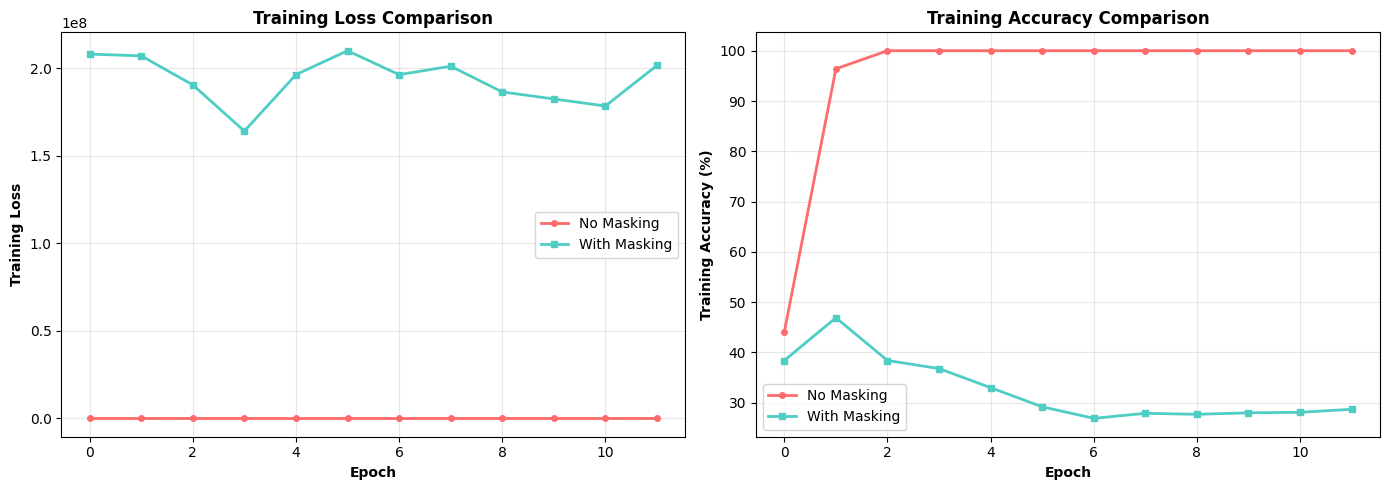

In [142]:
# Simple comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training curves
ax1.plot(losses_no_mask, 'o-', label='No Masking', color='#FF6B6B', linewidth=2, markersize=4)
ax1.plot(losses_with_mask, 's-', label='With Masking', color='#4ECDC4', linewidth=2, markersize=4)
ax1.set_xlabel('Epoch', fontweight='bold')
ax1.set_ylabel('Training Loss', fontweight='bold')
ax1.set_title('Training Loss Comparison', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(accs_no_mask, 'o-', label='No Masking', color='#FF6B6B', linewidth=2, markersize=4)
ax2.plot(accs_with_mask, 's-', label='With Masking', color='#4ECDC4', linewidth=2, markersize=4)
ax2.set_xlabel('Epoch', fontweight='bold')
ax2.set_ylabel('Training Accuracy (%)', fontweight='bold')
ax2.set_title('Training Accuracy Comparison', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Confusion Matrices

## Model Performance Analysis

Let's examine the confusion matrices to see how well each model performs on different sleep stages and whether logit masking improves classification consistency.

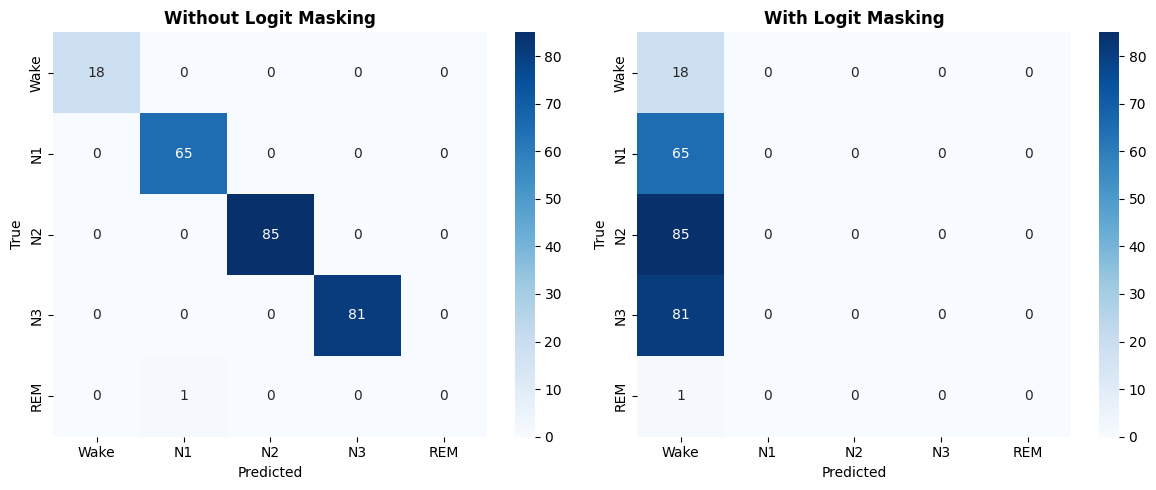

In [143]:
# Simple confusion matrix comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

cm_no_mask = confusion_matrix(true_labels, preds_no_mask)
cm_with_mask = confusion_matrix(true_labels, preds_with_mask)

# Plot confusion matrices
sns.heatmap(cm_no_mask, annot=True, fmt='d', cmap='Blues', 
            xticklabels=STAGES, yticklabels=STAGES, ax=ax1)
ax1.set_title('Without Logit Masking', fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

sns.heatmap(cm_with_mask, annot=True, fmt='d', cmap='Blues', 
            xticklabels=STAGES, yticklabels=STAGES, ax=ax2)
ax2.set_title('With Logit Masking', fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

## Conclusion

This example demonstrates the concept of logit masking for sleep stage classification. Here are the key takeaways:

### **What is Logit Masking?**
- Setting invalid class logits to `-inf` before applying softmax
- Enforces domain-specific constraints (like valid sleep stage transitions)
- Applied before loss computation, not after softmax

### **When Logit Masking Helps:**
- **Real sequential data** with strong temporal dependencies
- **Well-defined transition rules** that are physiologically meaningful
- **Inference time** when you want to enforce consistency

### **Why It Might Not Help Here:**
1. **Synthetic data** may not have realistic transition patterns
2. **Random previous stages** don't reflect real temporal sequences  
3. **Training benefits** from seeing all possible transitions to learn robust features

### **In Practice:**
- Most effective with real EEG data and proper sequence modeling
- Can be combined with RNNs/LSTMs that naturally track temporal context
- Often more beneficial at inference than training time
- Useful for post-processing to ensure logical consistency

### **Code Usage:**
```python
# Simple function to apply masking
masked_logits = apply_logit_masking(logits, prev_stages, transition_matrix, use_masking=True)
```

The technique is valuable for enforcing domain knowledge in sequence prediction tasks, even if our simplified synthetic example doesn't show dramatic improvements.